In [1]:
from __future__ import print_function

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
Z_NUM = 20
batch_size = 100

In [5]:
data = input_data.read_data_sets("../data_mnist/", one_hot=True)

Extracting ../data_mnist/train-images-idx3-ubyte.gz
Extracting ../data_mnist/train-labels-idx1-ubyte.gz
Extracting ../data_mnist/t10k-images-idx3-ubyte.gz
Extracting ../data_mnist/t10k-labels-idx1-ubyte.gz


In [6]:
input_dat = tf.placeholder(tf.float32, [batch_size, 784])
features = tf.reshape(input_dat,[batch_size, 28, 28, 1])

In [7]:
fc1 = tf.nn.relu(tf.layers.conv2d(features, kernel_size=15, filters=16, name="RecogLayer1"))
fc2 = tf.nn.relu(tf.layers.conv2d(fc1, kernel_size=8, filters=32,  name="RecogLayer2"))
flat = tf.reshape(fc2,[batch_size, 7*7*32], name="RecogFlat")
z_mu    = tf.nn.relu(tf.layers.dense(flat, Z_NUM, name="MeanLayer"))
z_sigma = tf.nn.relu(tf.layers.dense(flat, Z_NUM, name="StddevLayer"))

sample = tf.random_normal([batch_size,Z_NUM], 0, 1, dtype=tf.float32)
sample_z = z_mu + (z_sigma * sample)



In [8]:
gc1   = tf.nn.relu(tf.layers.dense(sample_z, 7*7*32, name="GenNet1"))
z_img = tf.nn.relu(tf.reshape(gc1, [batch_size, 7, 7, 32]))
gc2   = tf.nn.relu(tf.layers.conv2d_transpose(z_img, filters=16, kernel_size=8,name="GenNet2"))

gc3   = tf.nn.sigmoid(tf.layers.conv2d_transpose(gc2, filters=1, kernel_size=15,  name="GenNet3"))

g_flat = tf.reshape(gc3, [batch_size, 28*28], name="GenFlat")

In [9]:
gen_loss = -tf.reduce_sum(input_dat * tf.log(1e-8 + g_flat) + (1-input_dat) * tf.log(1e-8 + 1 - g_flat),1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_sigma) - tf.log(tf.square(z_sigma)) - 1,1)

cost = tf.reduce_mean(gen_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [10]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)
print('Training...')
for ep in range(1):
    for i in range(20000):
        batch_xs, batch_ys = data.train.next_batch(batch_size)
        optimizer.run({input_dat: batch_xs})

        if i % batch_size*10 == 0:
            print('Epoch:%6d Step Done: %6d' % (ep,i))



Training...
Epoch:     0 Step Done:      0
Epoch:     0 Step Done:    100
Epoch:     0 Step Done:    200
Epoch:     0 Step Done:    300
Epoch:     0 Step Done:    400
Epoch:     0 Step Done:    500
Epoch:     0 Step Done:    600
Epoch:     0 Step Done:    700
Epoch:     0 Step Done:    800
Epoch:     0 Step Done:    900
Epoch:     0 Step Done:   1000
Epoch:     0 Step Done:   1100
Epoch:     0 Step Done:   1200
Epoch:     0 Step Done:   1300
Epoch:     0 Step Done:   1400
Epoch:     0 Step Done:   1500
Epoch:     0 Step Done:   1600
Epoch:     0 Step Done:   1700
Epoch:     0 Step Done:   1800
Epoch:     0 Step Done:   1900
Epoch:     0 Step Done:   2000
Epoch:     0 Step Done:   2100
Epoch:     0 Step Done:   2200
Epoch:     0 Step Done:   2300
Epoch:     0 Step Done:   2400
Epoch:     0 Step Done:   2500
Epoch:     0 Step Done:   2600
Epoch:     0 Step Done:   2700
Epoch:     0 Step Done:   2800
Epoch:     0 Step Done:   2900
Epoch:     0 Step Done:   3000
Epoch:     0 Step Done:   3

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

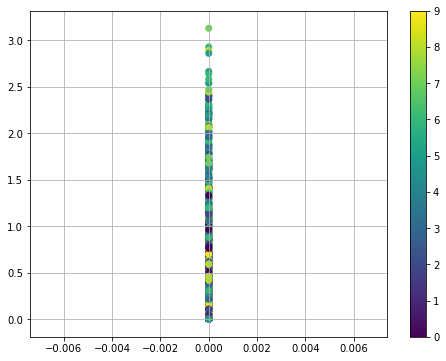

In [12]:
plt.figure(figsize=(8, 6)) 
for _ in range(10):
    x_sample, y_sample = data.test.next_batch(100)

    z_m = sess.run(z_mu,{input_dat:x_sample})
    plt.scatter(z_m[:, 0], z_m[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

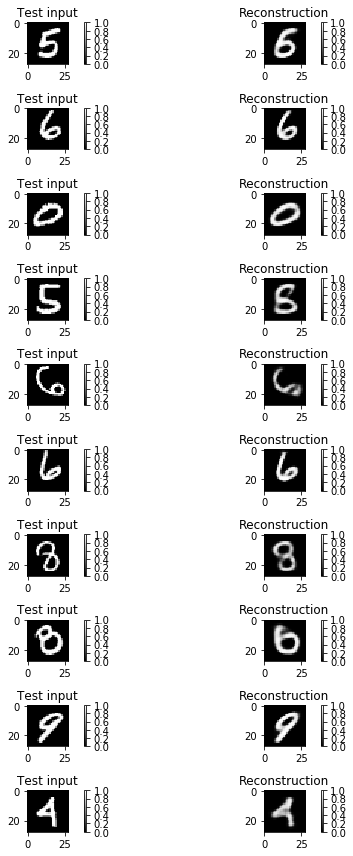

In [15]:
x_sample = data.test.next_batch(100)[0]
x_vae = sess.run(gc3, {input_dat:x_sample})
plt.figure(figsize=(8, 12))
for i in range(10):

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(x_vae[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()